# Frequency-Space Burstiness Analysis and Parameter Search

## Method

This notebook extends **Burstiness-AllReuters-v1.ipynb**:
   - Wavelet families (db, sym, coif, bior) across multiple levels.
   - Fourier band energy and spectral descriptors (centroid, slope).
   - Multiple window sizes for local features (8,16, 32, 64, 128).

## Goal
Determine whether frequency-domain structure in per-token log-probability
time series separates human-written from LLM-generated text in a way that
generalizes across datasets and graders.

In [1]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import pywt
from fingerprinting_llms.score import LogProbs

HUMAN_ROOT_LLAMA    = 'data/tokens/human_llama-graded/reuter5050/C50train_clean'
HUMAN_ROOT_MIXTRAL  = 'data/tokens/human_bigmixtral-graded/reuter5050/C50train_clean'
LLM_ROOT_LLAMA      = 'data/tokens/llama70Bw4a16/reuter5050/C50train_clean'
LLM_ROOT_MIXTRAL    = 'data/tokens/llama70Bw4a16-bigmixtral-graded/reuter5050/C50train_clean'

RNG = np.random.default_rng(42)


## Data Loading

We assume each document has been scored by a model and saved as `.npz` with
`token_probs` (per-token probabilities under the scorer). We convert to log p.
All downstream features operate on the 1D log-probability sequence.

In [13]:
def find_all_npz(root_dir: str) -> list[str]:
    return sorted(glob.glob(os.path.join(root_dir, '**', '*.npz'), recursive=True))

def load_logp_series_from_root(root_dir: str) -> list[np.ndarray]:
    paths = find_all_npz(root_dir)
    series = []
    for p in paths:
        if LogProbs is not None:
            lp = LogProbs.from_file(p)
            probs = np.asarray(lp.token_probs, dtype=np.float64)
        else:
            with np.load(p, allow_pickle=True) as npzfile:
                if 'token_probs' not in npzfile:
                    continue
                probs = np.asarray(npzfile['token_probs'], dtype=np.float64)

        #logp = np.log(np.clip(probs, 1e-45, 1.0))
        series.append(probs)
    return series


## Helpers

Rolling window utility for local statistics.

In [14]:
def rolling_windows(a: np.ndarray, window: int, step: int = 1) -> np.ndarray:
    if window < 2 or a.size < window:
        return np.empty((0, window), dtype=a.dtype)
    n = 1 + (a.size - window) // step
    shape = (n, window)
    strides = (a.strides[0]*step, a.strides[0])
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


## Feature Descriptions

### Fourier / Spectrum (global frequency structure)
- **fft_high_energy_ratio_cut{c}** (c ∈ {0.5, 0.75, 0.9})  
  Fraction of total power in frequencies ≥ c·f_Nyquist.  
  *How:* compute real FFT; power spectrum P = |FFT(x)|^2, then sum power above index floor(c·len(P)) divided by total power.  
  *Why:* higher ratios indicate more high-frequency fluctuation, a possible marker of local unpredictability.

- **spectral_centroid**  
  Power-weighted average frequency index: sum(k*P_k) / sum(P_k).  
  *Why:* measures where energy “lives” in the spectrum (low vs high frequencies).

- **spectral_slope**  
  Slope of a linear fit of log(P_k + epsilon) versus frequency index k.  
  *Why:* negative slopes indicate spectra dominated by low frequencies (smoother signals); flatter/positive slopes suggest relatively more high-frequency content.

---

### Wavelet (multi-scale energy and shape)
*(computed per wavelet family; names are prefixed, e.g., `db4_*`, `sym4_*`, `coif1_*`, `bior3.3_*`)*
**Notes on coefficients:**
- When you apply a discrete wavelet transform (DWT) to a signal, it splits the signal into two parts at each level:
  - Approximation coefficients (cA) — the low-frequency, slowly varying part (a coarse version of the signal).
  - Detail coefficients (cD) — the high-frequency fluctuations removed at that scale.
- Each level has its own cD array of detail coefficients.

- **{wav}_wavelet_hf_ratio**  
  High-frequency energy ratio: sum(detail energies) / (approx energy + sum(detail energies)).  
  *Why:* global measure of “burstiness” across detail bands; higher = more rapid local variation.

**Notes on detail levels:**
- Detail levels correspond to scales or frequency bands in the wavelet decomposition.
  - detailL1 is the highest-frequency fluctuations (shortest timescale)
  - detailL2 is on a lower frequency range and on a timescale that is twice as long as L1
  - detailL3 is on a lower frequency range still and on a timescale that is 4x as long as L1
- Detail energies show how much energy exists at each timescale of variation.

- **{wav}_detailL{i}_ratio** (i = 1…L)  
  Energy of detail level i divided by total energy. (i=1 >> highest frequencies; larger i = lower frequencies.)  
  *Why:* localizes where (which temporal scale) the energy concentrates; can reveal characteristic fluctuation scales.

- **{wav}_detail_entropy**  
  Shannon entropy of concatenated detail coefficients (via a normalized histogram).  
  *Why:* higher entropy suggests a more “disordered” distribution of wavelet details; lower entropy suggests concentrated/structured bursts.

- **{wav}_detail_kurt** (excess kurtosis)  
  *How:* Perform standard kurtosis formula on concatenated detail coefficients.  
  *Why:* large positive values indicate heavy tails / outliers in detail coefficients (rare, strong bursts).

> **More Wavelet Notes:**  
> - Different wavelet families (Daubechies/Symlets/Coiflets/Biorthogonal) emphasize sharpness vs smoothness differently; comparing families helps find robust signals.

---

### Local Burstiness (windowed statistics)
- **cv_local_mean_w{W}** (for W ∈ {8, 16, 32, 64, 128})  
  Mean of the **coefficient of variation** over sliding windows of width W: CV = std(window) / (|mean(window)| + epsilon), averaged across windows.  
  *Why:* scale-dependent burstiness; larger values indicate bigger fluctuations relative to local mean (after accounting for baseline).

---

### Practical Tips & Ranges
- **Ranges:** energy ratios ∈ [0, 1]; entropy >= 0 (depends on binning); kurtosis_excess can be negative or large positive; spectral slope typically negative for smooth series.  
- **Normalization:** features are computed on mean-centered log-p; you may optionally standardize feature columns before linear models.  
- **Interpretation:** “Higher high-frequency energy / entropy / kurtosis” generally reflects **more irregular, bursty** log-prob behavior; “lower” reflects **smoother** sequences.


## Fourier Features

- Power spectrum
- Band energy ratios
- Spectral centroid / slope

In [4]:
def fourier_power(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    X = np.fft.rfft(x)
    P = np.abs(X)**2
    return P

def fourier_energy_ratio(P: np.ndarray, frac_cut: float) -> float:
    if P.size == 0:
        return 0.0
    total = P.sum()
    if total <= 0:
        return 0.0
    cut = int(np.floor(frac_cut * P.size))
    high = P[cut:].sum()
    return float(high / total)

def spectral_centroid(P: np.ndarray) -> float:
    if P.size == 0:
        return 0.0
    w = np.arange(P.size, dtype=np.float64)
    denom = P.sum()
    if denom <= 0:
        return 0.0
    return float((w * P).sum() / denom)

def spectral_slope(P: np.ndarray) -> float:
    if P.size < 2:
        return 0.0
    w = np.arange(P.size, dtype=np.float64)
    y = np.log(P + 1e-12)
    w_mean = w.mean()
    y_mean = y.mean()
    num = np.sum((w - w_mean) * (y - y_mean))
    den = np.sum((w - w_mean)**2)
    if den <= 0:
        return 0.0
    return float(num / den)


## Wavelet Features

We decompose the log-prob sequence with multiple wavelet families and levels,
and compute:
- high-frequency / total energy ratio
- per-level detail energy ratios
- entropy and kurtosis of concatenated detail coefficients

In [5]:
def wavelet_decomp_features(x: np.ndarray,
                             wavelet_name: str,
                             max_levels: int = 5) -> dict[str, float]:
    feats: dict[str, float] = {}

    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()

    try:
        w = pywt.Wavelet(wavelet_name)
    except Exception as err:
        print(f"ERROR MAKING WAVELETS : {err}")
        return feats

    level_cap = pywt.dwt_max_level(len(x), w.dec_len)
    level = min(max_levels, max(1, level_cap))

    coeffs = pywt.wavedec(x, wavelet=w, level=level, mode='symmetric')
    approx = coeffs[0]
    details = coeffs[1:]

    energies = [np.sum(c*c) for c in coeffs]
    e_total = np.sum(energies)
    if e_total <= 0:
        return feats

    e_details = [np.sum(d*d) for d in details]
    e_high = np.sum(e_details)
    feats[f'{wavelet_name}_wavelet_hf_ratio'] = float(e_high / e_total)

    for i, e in enumerate(e_details, start=1):
        feats[f'{wavelet_name}_detailL{i}_ratio'] = float(e / e_total)

    all_detail = np.concatenate(details) if len(details) > 0 else np.array([], dtype=np.float64)
    if all_detail.size > 0:
        hist, edges = np.histogram(all_detail, bins=64, density=True)
        p = hist / (hist.sum() + 1e-12)
        ent = -np.sum(p * np.log(p + 1e-12))
        feats[f'{wavelet_name}_detail_entropy'] = float(ent)

        m2 = np.mean((all_detail - all_detail.mean())**2)
        m4 = np.mean((all_detail - all_detail.mean())**4)
        kurt_excess = m4 / (m2**2 + 1e-12) - 3.0 if m2 > 1e-12 else 0.0
        feats[f'{wavelet_name}_detail_kurt'] = float(kurt_excess)

    return feats


## Local CV Features

Coefficient of variation (std / |mean|) over rolling windows of different sizes
captures bursty local instability in the log-prob signal.

In [6]:
def windowed_cv_features(x: np.ndarray,
                         window_sizes=(8,16,32,64,128),
                         step_fraction=0.25) -> dict[str, float]:
    feats: dict[str, float] = {}
    for w in window_sizes:
        step = max(1, int(w * step_fraction))
        rw = rolling_windows(x, w, step=step)
        if rw.size == 0:
            feats[f'cv_local_mean_w{w}'] = np.nan
            continue
        mu = rw.mean(axis=1)
        sd = rw.std(axis=1, ddof=1)
        denom = np.maximum(np.abs(mu), 1e-8)
        cv = sd / denom
        feats[f'cv_local_mean_w{w}'] = float(np.nanmean(cv))
    return feats


## Master Feature Extractor

For a single log-probability sequence, build a feature dict combining:
- Fourier band ratios, centroid, slope
- Multi-wavelet energy stats
- Multi-scale local CV


In [7]:
WAVELETS_TO_TRY = ['db2','db4','db8','sym4','coif1','bior3.3']
FOURIER_FRAC_CUTS = [0.5, 0.75, 0.9]

def extract_features_from_logp(x: np.ndarray) -> dict[str, float]:
    feats: dict[str, float] = {}
    x = np.asarray(x, dtype=np.float64)

    #   Fourier feaures
    P = fourier_power(x)
    for cut in FOURIER_FRAC_CUTS:
        feats[f'fft_high_energy_ratio_cut{cut}'] = fourier_energy_ratio(P, cut)
    feats['spectral_centroid'] = spectral_centroid(P)
    feats['spectral_slope']    = spectral_slope(P)

    #   Wavelets
    for wname in WAVELETS_TO_TRY:
        wf = wavelet_decomp_features(x, wavelet_name=wname, max_levels=5)
        for k,v in wf.items():
            feats[k] = v
    else:
        feats['wavelet_missing'] = 1.0

    feats.update(windowed_cv_features(x, window_sizes=(8,16,32,64,128), step_fraction=0.25))

    return feats


## Build Feature Tables

We:
1. Load human-scored docs
2. Load llm-generated-scored docs
3. Extract features for each and label them


In [8]:
def build_feature_df(human_root: str, llm_root: str) -> pd.DataFrame:
    human_series = load_logp_series_from_root(human_root)
    llm_series   = load_logp_series_from_root(llm_root)

    rows = []
    for idx, seq in enumerate(human_series):
        feats = extract_features_from_logp(seq)
        feats['label'] = 'human'
        feats['doc_id'] = f'human_{idx}'
        rows.append(feats)

    for idx, seq in enumerate(llm_series):
        feats = extract_features_from_logp(seq)
        feats['label'] = 'llm'
        feats['doc_id'] = f'llm_{idx}'
        rows.append(feats)

    df = pd.DataFrame(rows)
    return df.reset_index(drop=True)


## Stratified Train/Val Split

We hold out 20% for validation.

In [9]:
def stratified_train_val_split(df_in: pd.DataFrame, test_size: float = 0.2, seed: int = 42):
    y = (df_in['label'] == 'human').astype(int).values
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    (train_idx, val_idx) = next(splitter.split(df_in, y))
    train_df = df_in.iloc[train_idx].reset_index(drop=True)
    val_df   = df_in.iloc[val_idx].reset_index(drop=True)
    return train_df, val_df


## Train Random Forest and Evaluate

We train a RF, get CV metrics on the train split, and then evaluate on held-out validation.
We also produce a confusion matrix and feature importances.

In [10]:
def model_eval_random_forest(train_df: pd.DataFrame, val_df: pd.DataFrame, title: str = ""):
    feature_cols = [c for c in train_df.columns if c not in ('label','doc_id')]
    numeric_cols = []
    for c in feature_cols:
        if pd.api.types.is_numeric_dtype(train_df[c]) and not train_df[c].isna().all():
            numeric_cols.append(c)

    X_train = train_df[numeric_cols].copy().fillna(train_df[numeric_cols].mean())
    X_val   = val_df[numeric_cols].copy().fillna(train_df[numeric_cols].mean())

    le = LabelEncoder()
    le.fit(train_df['label'])
    y_train = le.transform(train_df['label'])
    y_val   = le.transform(val_df['label'])

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1,
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scoring = {
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
    }
    cv_results = cross_validate(
        rf, X_train, y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_estimator=False,
    )

    print(f"=== {title} : Cross-validated TRAIN performance ===")
    print(f"accuracy:        {cv_results['test_accuracy'].mean():.3f} ± {cv_results['test_accuracy'].std():.3f}")
    print(f"precision_macro: {cv_results['test_precision_macro'].mean():.3f} ± {cv_results['test_precision_macro'].std():.3f}")
    print(f"recall_macro:    {cv_results['test_recall_macro'].mean():.3f} ± {cv_results['test_recall_macro'].std():.3f}")
    print(f"f1_macro:        {cv_results['test_f1_macro'].mean():.3f} ± {cv_results['test_f1_macro'].std():.3f}")

    rf.fit(X_train, y_train)
    y_val_pred = rf.predict(X_val)
    y_val_proba = rf.predict_proba(X_val)[:,1]

    acc  = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='macro', zero_division=0)
    rec  = recall_score(y_val, y_val_pred, average='macro', zero_division=0)
    f1m  = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
    try:
        auroc = roc_auc_score(y_val, y_val_proba)
    except ValueError:
        auroc = np.nan

    print(f"\n=== {title} : VALIDATION performance ===")
    print(f"accuracy (val):        {acc:.3f}")
    print(f"precision_macro (val): {prec:.3f}")
    print(f"recall_macro (val):    {rec:.3f}")
    print(f"f1_macro (val):        {f1m:.3f}")
    print(f"AUROC (val):           {auroc:.3f}")

    cm = confusion_matrix(y_val, y_val_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform([0,1]))
    disp.plot(values_format='d')
    plt.title(f'{title} : Validation Confusion Matrix')
    plt.show()

    importances = pd.Series(rf.feature_importances_, index=numeric_cols).sort_values(ascending=False)
    display(importances.head(20))
    plt.figure(figsize=(6,4))
    importances.head(20).iloc[::-1].plot(kind='barh')
    plt.xlabel('RF Feature Importance (Gini)')
    plt.title(f'{title} : Top Feature Importances')
    plt.tight_layout()
    plt.show()

    return {
        'model': rf,
        'numeric_cols': numeric_cols,
        'label_encoder': le,
        'val_predictions': y_val_pred,
        'val_truth': y_val,
        'val_proba': y_val_proba,
        'val_feature_importances': importances,
    }


## Main Experiments

### A. Human-generated, LLaMA-graded vs LLaMA-generated, LLaMA-graded
- Uses `HUMAN_ROOT_LLAMA` vs `LLM_ROOT_LLAMA`

### B. Human-generated, Mixtral-graded vs LLaMA-generated, Mixtral-graded
- Uses `HUMAN_ROOT_MIXTRAL` vs `LLM_ROOT_MIXTRAL`

=== LLaMA-graded (Human vs LLaMA-gen) : Cross-validated TRAIN performance ===
accuracy:        0.981 ± 0.004
precision_macro: 0.982 ± 0.004
recall_macro:    0.980 ± 0.004
f1_macro:        0.981 ± 0.004

=== LLaMA-graded (Human vs LLaMA-gen) : VALIDATION performance ===
accuracy (val):        0.975
precision_macro (val): 0.975
recall_macro (val):    0.973
f1_macro (val):        0.974
AUROC (val):           0.996


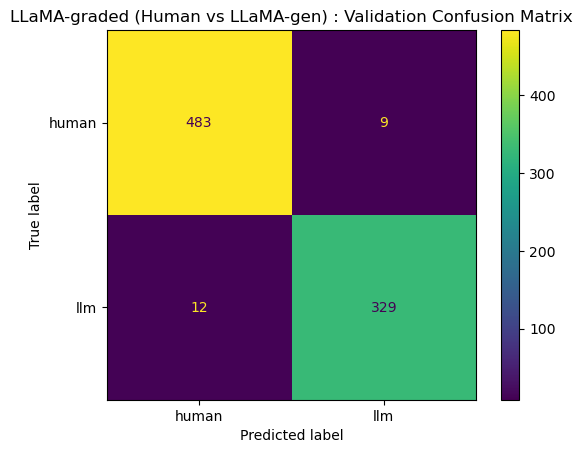

sym4_detail_kurt          0.097569
db4_detail_kurt           0.096401
coif1_detail_kurt         0.083943
db2_detail_kurt           0.075354
cv_local_mean_w128        0.073861
cv_local_mean_w64         0.064956
coif1_wavelet_hf_ratio    0.049832
sym4_detailL5_ratio       0.048897
spectral_centroid         0.043089
sym4_wavelet_hf_ratio     0.042417
coif1_detailL5_ratio      0.035172
db2_detailL5_ratio        0.035056
db2_wavelet_hf_ratio      0.034533
db8_detail_kurt           0.027543
coif1_detail_entropy      0.025625
sym4_detail_entropy       0.024785
db2_detail_entropy        0.023476
db4_detail_entropy        0.010112
cv_local_mean_w32         0.008732
db4_detailL4_ratio        0.008480
dtype: float64

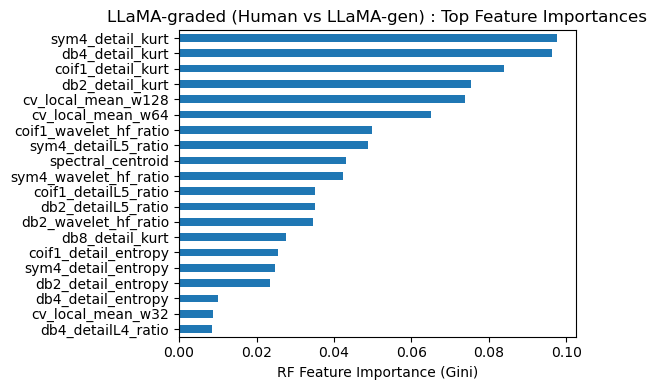

In [15]:
# --- A. Human vs LLaMA-generated, scored by LLaMA ---
df_llama_scored = build_feature_df(HUMAN_ROOT_LLAMA, LLM_ROOT_LLAMA)
train_llama, val_llama = stratified_train_val_split(df_llama_scored, test_size=0.2, seed=42)
res_llama = model_eval_random_forest(train_llama, val_llama, title='LLaMA-graded (Human vs LLaMA-gen)')


/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(


=== Mixtral-graded (Human vs LLaMA-gen) : Cross-validated TRAIN performance ===
accuracy:        0.852 ± 0.008
precision_macro: 0.847 ± 0.008
recall_macro:    0.783 ± 0.017
f1_macro:        0.804 ± 0.014

=== Mixtral-graded (Human vs LLaMA-gen) : VALIDATION performance ===
accuracy (val):        0.853
precision_macro (val): 0.846
recall_macro (val):    0.783
f1_macro (val):        0.805
AUROC (val):           0.885


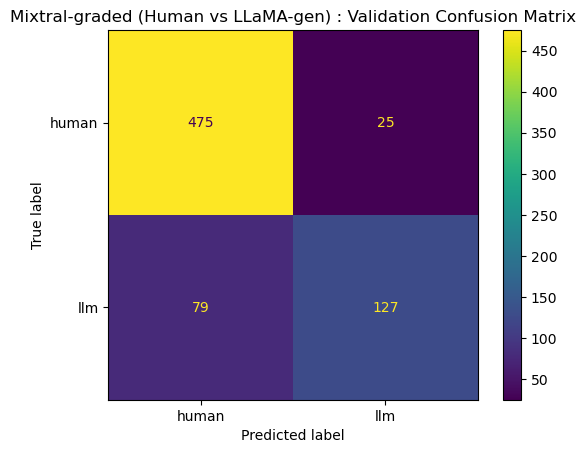

cv_local_mean_w64         0.074564
cv_local_mean_w128        0.067797
spectral_centroid         0.065338
cv_local_mean_w32         0.046682
cv_local_mean_w16         0.045013
cv_local_mean_w8          0.035924
sym4_detail_kurt          0.033684
coif1_detail_kurt         0.029645
db2_detail_kurt           0.027212
sym4_detail_entropy       0.024828
spectral_slope            0.021471
db4_detail_entropy        0.019154
bior3.3_detail_entropy    0.019119
bior3.3_detail_kurt       0.018176
coif1_detail_entropy      0.017213
db4_detail_kurt           0.016160
db2_detail_entropy        0.015320
db2_wavelet_hf_ratio      0.014677
db2_detailL5_ratio        0.014483
sym4_detailL1_ratio       0.014175
dtype: float64

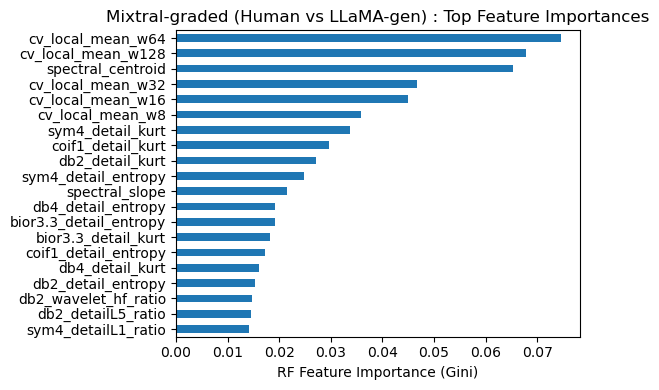

In [17]:
# --- B. Human vs LLaMA-generated, scored by Mixtral ---
df_mixtral_scored = build_feature_df(HUMAN_ROOT_MIXTRAL, LLM_ROOT_MIXTRAL)
train_mix, val_mix = stratified_train_val_split(df_mixtral_scored, test_size=0.2, seed=42)
res_mix = model_eval_random_forest(train_mix, val_mix, title='Mixtral-graded (Human vs LLaMA-gen)')


# Results

## HGLG vs LGLG Results

- HGLG vs. LGLG achieved slightly higher performance than the **Burstiness-AllReuters-v1.ipynb** notebook, F1 score of **0.98** vs **0.97**
- Wavelet `detail` features have highest importance, indicating high frequency components playing a strong role
- `cv_local_mean` still very important

## HGMG vs LGMG Results

- HGMG vs. LGMG results were decent, but interestingly no better than the **Burstiness-AllReuters-v1.ipynb** despite the vast increase in features
- `cv_local_mean` is the most important feature, remaining consistent with what we saw in the -v1 notebook
